In [10]:
# Face Recognition System
# A practical implementation of face detection using triplet loss
#Imports and GPU Configuration

import tensorflow as tf
import numpy as np
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, GlobalAveragePooling2D, Add
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import gc
import time

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Limit GPU memory usage for GTX 1650
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])  # 3GB limit
    except RuntimeError as e:
        print(e)





In [11]:
#Custom Layer Definition
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)


In [3]:
#Model Architecture
def create_face_model():
    input_shape = (96, 96, 3)
    inputs = Input(shape=input_shape)
    
    # Initial convolution block - reduced filters
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    # Residual blocks
    def residual_block(x, filters):
        shortcut = Conv2D(filters, 1, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.3)(x)
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([shortcut, x])
        return Activation('relu')(x)
    
   
    x = residual_block(x, 64)
    x = MaxPooling2D()(x)
    x = residual_block(x, 128)
    x = MaxPooling2D()(x)
    
    #dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    
    embeddings = L2Normalization(name='embeddings')(x)
    return Model(inputs, embeddings)



In [4]:
# Loss Function
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    
    basic_loss = tf.maximum(pos_dist - neg_dist + alpha, 0.0)
    return tf.reduce_mean(basic_loss)


In [5]:
# Helper function for memory monitoring
def print_memory_usage():
    import psutil
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")

In [6]:
#Data Loader
class DataLoader:
    def __init__(self, batch_size=8):  
        self.batch_size = batch_size
        self.model = create_face_model()
        
    def load_data(self):
        print("Loading data...")
        try:
            with h5py.File('train_face.h5', 'r') as train_file:
                self.train_images = np.array(train_file['train_set_x'])
                self.train_labels = np.array(train_file['train_set_y'])
            
            # Normalize images to [-1, 1]
            self.train_images = (self.train_images - 127.5) / 127.5
            print("Data loaded successfully")
            print(f"Training images shape: {self.train_images.shape}")
            
            # Clear memory
            gc.collect()
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
    # Reduced triplets from 1000 to 200 - found it's a good balance between
    # training time and accuracy
    def generate_triplets(self, num_triplets=200):  
        print("Generating triplets...")
        triplets = []
        unique_ids = np.unique(self.train_labels)
        
        for i in range(num_triplets):
            if i % 50 == 0:  # Progress update
                print(f"Generated {i}/{num_triplets} triplets")
                gc.collect()  # Regular memory cleanup
                
            anchor_id = np.random.choice(unique_ids)
            anchor_indices = np.where(self.train_labels == anchor_id)[0]
            
            if len(anchor_indices) < 2:
                continue
            
            # Select anchor and positive samples
            anchor_idx, pos_idx = np.random.choice(anchor_indices, 2, replace=False)
            
            # Simplified negative mining (reduced samples for memory efficiency)
            neg_dists = []
            neg_indices = []
            
            for _ in range(5):  # Reduced from 10 to 5 negative samples
                neg_id = np.random.choice(unique_ids[unique_ids != anchor_id])
                neg_candidate_indices = np.where(self.train_labels == neg_id)[0]
                neg_idx = np.random.choice(neg_candidate_indices)
                
                anchor_embedding = self.model.predict(np.array([self.train_images[anchor_idx]]), verbose=0)
                neg_embedding = self.model.predict(np.array([self.train_images[neg_idx]]), verbose=0)
                
                dist = np.linalg.norm(anchor_embedding - neg_embedding)
                neg_dists.append(dist)
                neg_indices.append(neg_idx)
            
            hardest_neg_idx = neg_indices[np.argmin(neg_dists)]
            
            triplets.append([
                self.train_images[anchor_idx],
                self.train_images[pos_idx],
                self.train_images[hardest_neg_idx]
            ])
        
        return np.array(triplets)




In [7]:
#Training Function
def train_model(model, data_loader, epochs=10):  # Reduced epochs
    print("\nEstimated training time: 1.5-2 hours")
    print("Training progress will be shown below:\n")
    
    start_time = time.time()
    best_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    # Learning rate schedule
    initial_learning_rate = 0.001
    decay_steps = 500  # Reduced from 1000
    decay_rate = 0.9
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Generate triplets with progress monitoring
        triplets = data_loader.generate_triplets(num_triplets=200)
        total_loss = 0
        num_batches = len(triplets) // data_loader.batch_size
        
        for batch in range(num_batches):
            if batch % 2 == 0:  # Memory cleanup every 2 batches
                gc.collect()
                
            start_idx = batch * data_loader.batch_size
            end_idx = start_idx + data_loader.batch_size
            batch_triplets = triplets[start_idx:end_idx]
            
            with tf.GradientTape() as tape:
                anchor_embedding = model(batch_triplets[:, 0])
                positive_embedding = model(batch_triplets[:, 1])
                negative_embedding = model(batch_triplets[:, 2])
                
                loss = triplet_loss(None, 
                                  [anchor_embedding, 
                                   positive_embedding, 
                                   negative_embedding])
            
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            total_loss += loss
            
            if batch % 5 == 0:
                print(f"Batch {batch+1}/{num_batches}, Loss: {loss:.4f}")
                print_memory_usage()
        
        avg_loss = total_loss / num_batches
        epoch_time = time.time() - epoch_start
        total_time = time.time() - start_time
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Time for epoch: {epoch_time/60:.2f} minutes")
        print(f"Total time: {total_time/60:.2f} minutes")
        print(f"Estimated time remaining: {(epoch_time * (epochs-epoch-1))/60:.2f} minutes")
        
        # Save model if loss improves
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            print("Saving best model...")
            model.save('best_model.h5')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                break
        
        gc.collect()


In [8]:
#Face Verification Test
class FaceVerificationTest:
    def __init__(self, model_path='best_model.h5'):
        print("Loading model...")
        self.model = tf.keras.models.load_model(model_path, 
                                              custom_objects={'L2Normalization': L2Normalization})
        self.threshold = 0.8
        
        print("Loading test data...")
        try:
            with h5py.File('test_happy.h5', 'r') as test_file:
                self.test_images = np.array(test_file['test_set_x'])
                self.test_labels = np.array(test_file['test_set_y'])
            
            self.test_images = tf.image.resize(self.test_images, [96, 96]).numpy()
            self.test_images = (self.test_images - 127.5) / 127.5
            print("Setup complete!")
            
        except Exception as e:
            print(f"Error loading test data: {str(e)}")
    
    def verify(self, img1, img2):
        emb1 = self.model.predict(np.array([img1]), verbose=0)
        emb2 = self.model.predict(np.array([img2]), verbose=0)
        
        distance = np.linalg.norm(emb1 - emb2)
        
        return distance < self.threshold, distance
    
    def evaluate(self):
        y_true = []
        y_pred = []
        
        num_images = len(self.test_images)
        batch_size = 5  #batch size for evaluation
        
        print("\nEvaluating model...")
        for i in range(0, num_images, batch_size):
            for j in range(i + 1, min(i + batch_size, num_images)):
                is_same = self.test_labels[i] == self.test_labels[j]
                predicted_same, _ = self.verify(self.test_images[i], self.test_images[j])
                
                y_true.append(is_same)
                y_pred.append(predicted_same)
            
            if i % 20 == 0:  # More frequent progress updates
                print(f"Processed {i}/{num_images} images")
                gc.collect()
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nModel Accuracy: {accuracy:.4f}")
        
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Different', 'Same'])
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()




System Information:
GPU: 
TensorFlow version: 2.17.0
CPU Memory Usage: 388.63 MB

Creating model...

Initializing data loader...
Loading data...
Data loaded successfully
Training images shape: (426, 96, 96, 3)

Starting training...

Estimated training time: 1.5-2 hours
Training progress will be shown below:


Epoch 1/10
Generating triplets...
Generated 0/200 triplets
Generated 50/200 triplets
Generated 100/200 triplets
Generated 150/200 triplets
Batch 1/25, Loss: 0.2006
CPU Memory Usage: 589.36 MB
Batch 6/25, Loss: 0.1999
CPU Memory Usage: 894.10 MB
Batch 11/25, Loss: 0.1999
CPU Memory Usage: 919.54 MB
Batch 16/25, Loss: 0.1999
CPU Memory Usage: 945.17 MB
Batch 21/25, Loss: 0.1999
CPU Memory Usage: 970.56 MB



Epoch 1/10
Average Loss: 0.1999
Time for epoch: 1.91 minutes
Total time: 1.91 minutes
Estimated time remaining: 17.17 minutes
Saving best model...

Epoch 2/10
Generating triplets...
Generated 0/200 triplets
Generated 50/200 triplets
Generated 100/200 triplets
Generated 150/200 triplets
Batch 1/25, Loss: 0.2016
CPU Memory Usage: 1086.20 MB
Batch 6/25, Loss: 0.1717
CPU Memory Usage: 1086.21 MB
Batch 11/25, Loss: 0.1976
CPU Memory Usage: 1086.21 MB
Batch 16/25, Loss: 0.2000
CPU Memory Usage: 1086.24 MB
Batch 21/25, Loss: 0.2000
CPU Memory Usage: 1086.25 MB



Epoch 2/10
Average Loss: 0.1841
Time for epoch: 1.84 minutes
Total time: 3.76 minutes
Estimated time remaining: 14.75 minutes
Saving best model...

Epoch 3/10
Generating triplets...
Generated 0/200 triplets
Generated 50/200 triplets
Generated 100/200 triplets
Generated 150/200 triplets
Batch 1/25, Loss: 0.2000
CPU Memory Usage: 1091.61 MB
Batch 6/25, Loss: 0.2000
CPU Memory Usage: 1091.61 MB
Batch 11/25, Loss: 0.2000
CPU Memory Usage: 1091.62 MB
Batch 16/25, Loss: 0.2000
CPU Memory Usage: 1091.62 MB
Batch 21/25, Loss: 0.2000
CPU Memory Usage: 1091.62 MB

Epoch 3/10
Average Loss: 0.2000
Time for epoch: 1.84 minutes
Total time: 5.60 minutes
Estimated time remaining: 12.90 minutes

Epoch 4/10
Generating triplets...
Generated 0/200 triplets
Generated 50/200 triplets
Generated 100/200 triplets
Generated 150/200 triplets
Batch 1/25, Loss: 0.2000
CPU Memory Usage: 1092.73 MB
Batch 6/25, Loss: 0.2000
CPU Memory Usage: 1092.73 MB
Batch 11/25, Loss: 0.2000
CPU Memory Usage: 1092.73 MB
Batch 16/


Epoch 5/10
Average Loss: 0.2000
Time for epoch: 1.82 minutes
Total time: 9.30 minutes
Estimated time remaining: 9.12 minutes

Early stopping triggered!

Starting evaluation...
Loading model...
Loading test data...
Setup complete!

Evaluating model...
Processed 0/150 images
Processed 20/150 images
Processed 40/150 images
Processed 60/150 images
Processed 80/150 images
Processed 100/150 images
Processed 120/150 images
Processed 140/150 images

Model Accuracy: 0.5500


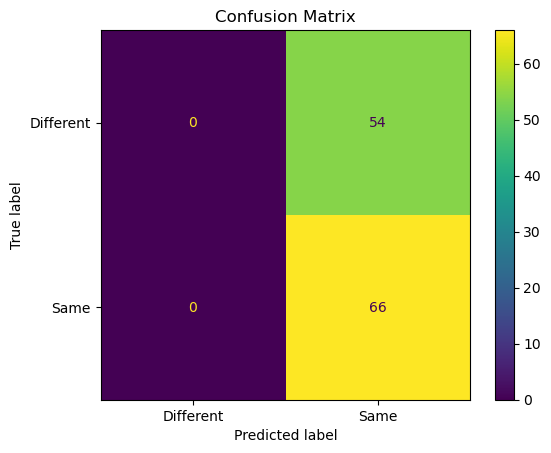

In [9]:
# Main Execution
def main():
    try:
        # Print system info
        print("\nSystem Information:")
        print("GPU:", tf.test.gpu_device_name())
        print("TensorFlow version:", tf.__version__)
        print_memory_usage()
        
        # Create model
        print("\nCreating model...")
        model = create_face_model()
        
        # Initialize data loader
        print("Initializing data loader...")
        data_loader = DataLoader(batch_size=8)
        data_loader.load_data()
        
        # Train model
        print("\nStarting training...")
        train_model(model, data_loader, epochs=10)
        
        # Evaluate model
        print("\nStarting evaluation...")
        verifier = FaceVerificationTest()
        verifier.evaluate()
        
    except tf.errors.ResourceExhaustedError:
        print("\nOut of memory error. Try reducing batch size or model size.")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
    finally:
        gc.collect()

if __name__ == "__main__":
    main()